In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
import re
from IPython.display import display

### Part 0: Load Data

In [122]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [123]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [124]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating"]].rename(columns={"Book Id":"book_id", "My Rating":"rating"}).query("rating > 0")

# Reformat to fit sparse matrix
my_books = pd.merge(book_index, my_books, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# Replace 0 with 0.1 to prevent cosine similarities from zeroing
sparse_fill = 0.001
df_reviews.data[df_reviews.data == 0] = sparse_fill

### Part 1: Find Similar Users

In [125]:
### NOT WORKING AS EXPECTED -- NEED TO FIX

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

In [126]:
# Instantiate KNN
n_neighbors = 75
target_user = df_reviews.shape[0] - 1

nn_model = NearestNeighbors(
    metric="cosine",
    algorithm="auto",
    n_neighbors=n_neighbors,
    n_jobs=-1
)

# Fit to sparse matrix
nn_model.fit(df_reviews)

# Feed in user and get neighbors and distances
reader = df_reviews[target_user,:].toarray()
dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

similar_users = pd.DataFrame(
    [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"user", 1:"distance"}
)

similar_users.head()

,user,distance
0,245119.0,0.000000
1,68871.0,0.804018
2,169157.0,0.809443
3,242451.0,0.827690
4,147443.0,0.831460


In [127]:
# Get all books read by similar users
book_ind = []
book_rat = []
uid = []
target_user_books = []
target_user_book_rat = []
for nt in similar_users.itertuples():
    user = df_reviews[int(nt.user),:].toarray()
    book_inds = np.where(user[0] > 0)[0]
    ratings = user[0][np.where(user[0] > 0)[0]]
    for i in range(len(book_inds)):        
        book_ind.append(book_inds[i])
        book_rat.append(ratings[i])
        uid.append(nt.user)    
        if nt.distance < 0.000000001:
            target_user_books.append(book_inds[i])
            target_user_book_rat.append(ratings[i])

neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(columns={0:"uid",1:"book_index",2:"user_rating"})

# Join overall rating for each book
neighbor_user_ratings = pd.merge(book_index.reset_index(), neighbor_user_ratings, how="inner", left_on="index", right_on="book_index")
neighbor_user_ratings = pd.merge(neighbor_user_ratings, df_books, how="inner", on="book_id")

# Filter out books target reader has already read
neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
neighbor_user_ratings.drop(["index", "book_index"], axis=1, inplace=True)

# Filter out later volumes in series using regex pattern
regex = r"#([2-9]|[1-9]\d+)"
neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex)]

# Weight user book rating by cosine similarity

# Average weighted user book rating and overall avg rating

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_43473/3760903270.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex)]


In [128]:
# View neighbors rating table
neighbor_user_ratings.head()

,book_id,uid,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,url,...,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25,Genre_26,Genre_27,Genre_28,Genre_29,Genre_30
0,100915,83359.0,0.267860,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,2005,eng,https://images.gr-assets.com/books/1353029077m...,https://www.goodreads.com/book/show/100915.The...,...,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203,0.006203
1,10127019,149314.0,0.114992,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,2011,en-US,https://images.gr-assets.com/books/1333576876m...,https://www.goodreads.com/book/show/10127019-t...,...,0.006120,0.006120,0.006120,0.006120,0.006120,0.006120,0.006120,0.006120,0.006120,0.006120
2,10193060,122168.0,0.248452,Miserere: An Autumn Tale,3.79,747.0,2011,eng,https://images.gr-assets.com/books/1301084223m...,https://www.goodreads.com/book/show/10193060-m...,...,0.006900,0.006900,0.006900,0.006900,0.006900,0.006900,0.006900,0.006900,0.006900,0.799888
3,10245518,133863.0,0.158986,The Checklist Manifesto How to Get Things Right,4.03,268.0,2011,eng,https://images.gr-assets.com/books/1356488549m...,https://www.goodreads.com/book/show/10245518-t...,...,0.004778,0.004778,0.004778,0.004778,0.004778,0.004778,0.004778,0.004778,0.004778,0.004778
4,10321016,204297.0,0.368230,Pitch Anything: An Innovative Method for Prese...,4.09,4346.0,2011,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/10321016-p...,...,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926,0.004926


In [129]:
# View target user's ratings
target_user_ratings = pd.DataFrame([target_user_books, target_user_book_rat]).T.rename(columns={0:"book_index",1:"user_rating"})
target_user_ratings = pd.merge(book_index.reset_index(), target_user_ratings, how="inner", left_on="index", right_on="book_index")
target_user_ratings = pd.merge(target_user_ratings, df_books, how="inner", on="book_id")
target_user_ratings.head(10)

,index,book_id,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_21,Genre_22,Genre_23,Genre_24,Genre_25,Genre_26,Genre_27,Genre_28,Genre_29,Genre_30
0,159556,12352452,159556.0,0.084853,"Season of the Witch: Enchantment, Terror and D...",4.22,2481.0,2012,NaN,https://images.gr-assets.com/books/1329324459m...,...,0.004351,0.004351,0.004351,0.004351,0.004351,0.004351,0.004351,0.873825,0.004351,0.004351
1,222333,13166586,222333.0,0.084853,The Fish That Ate the Whale: The Life and Time...,3.97,1497.0,2012,eng,https://images.gr-assets.com/books/1327473440m...,...,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617,0.004617
2,270440,13554058,270440.0,0.084853,The Wandering Earth,4.01,894.0,2012,eng,https://images.gr-assets.com/books/1332444998m...,...,0.006766,0.803785,0.006766,0.006766,0.006766,0.006766,0.006766,0.006766,0.006766,0.006766
3,340694,15195,340694.0,0.113137,"The Complete Maus (Maus, #1-2)",4.53,79457.0,2003,en-GB,https://images.gr-assets.com/books/1327354180m...,...,0.006306,0.301228,0.006306,0.006306,0.006306,0.006306,0.006306,0.006306,0.006306,0.006306
4,442607,16256798,442607.0,0.056569,The One Thing: The Surprisingly Simple Truth B...,4.15,15237.0,2013,eng,https://images.gr-assets.com/books/1362177469m...,...,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584,0.009584
5,562115,17987621,562115.0,0.084853,The Entrepreneurial State: Debunking Public vs...,3.89,358.0,2013,NaN,https://images.gr-assets.com/books/1369818314m...,...,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042,0.005042
6,568445,18050143,568445.0,0.056569,"Zero to One: Notes on Startups, or How to Buil...",4.17,52400.0,2014,eng,https://images.gr-assets.com/books/1414347376m...,...,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848,0.004848
7,623534,18490568,623534.0,0.084853,"Age of Ambition: Chasing Fortune, Truth, and F...",4.23,3432.0,2014,eng,https://images.gr-assets.com/books/1418113377m...,...,0.004634,0.004634,0.004634,0.004634,0.004634,0.004634,0.004634,0.865622,0.004634,0.004634
8,657155,18778874,657155.0,0.056569,The Second Amendment,4.01,430.0,2014,eng,https://images.gr-assets.com/books/1397767878m...,...,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390,0.005390
9,754447,20588662,754447.0,0.084853,An Indigenous Peoples' History of the United S...,4.27,1225.0,2014,NaN,https://images.gr-assets.com/books/1395003842m...,...,0.006088,0.006088,0.006088,0.006088,0.006088,0.006088,0.006088,0.823436,0.006088,0.006088


In [130]:
# 20 most popular books among similar readers
popular_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
    .nlargest(20, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)

popular_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
226,The Gunslinger,3.98,346978.0,1982,5.3%
186,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,1997,4.0%
131,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,4.0%
100,Judas Unchained,4.30,21306.0,2005,2.7%
13,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,2.7%
300,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.7%
221,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,2.7%
77,"Gateway (Heechee Saga, #1)",4.07,30282.0,2004,2.7%
157,"Ringworld (Ringworld, #1)",3.96,78483.0,2005,2.7%
231,The Hike,3.92,5603.0,2016,2.7%


In [131]:
# 10 highest rated books among similar readers
highest_rated_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
    .nlargest(20, "avg_rating").rename(columns={"book_id":"percent_similar_users_read"})

highest_rated_recs["percent_similar_users_read"] = highest_rated_recs["percent_similar_users_read"] / n_neighbors

for i in range(n_neighbors,-1,-1):
    results = highest_rated_recs.query("percent_similar_users_read > (@i / @n_neighbors)")    
    if len(results) >= 10:
        print(i)
        break

results

0


,title,avg_rating,ratings_count,year,percent_similar_users_read
264,The Story of Human Language,4.44,394.0,2004,0.013333
273,"The Walking Dead, Compendium 1",4.43,58434.0,2009,0.013333
104,"Kings of the Wyld (The Band, #1)",4.42,2285.0,2017,0.013333
10,Adventure Time With Fionna and Cake,4.41,2542.0,2013,0.013333
54,David Attenborough's Life on Air: Memoirs of a...,4.39,1836.0,2003,0.013333
28,"Berserk, Vol. 1 (Berserk, #1)",4.38,10778.0,2003,0.013333
242,The Looming Tower: Al-Qaeda and the Road to 9/11,4.38,13019.0,2006,0.013333
85,Homicide: A Year on the Killing Streets,4.37,10487.0,1991,0.013333
164,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0,2013,0.013333
202,The Complete Works of H.P. Lovecraft,4.34,9733.0,2011,0.013333


In [132]:
# Best recommendations based on rating, popularity, and user similarity


In [133]:
# Filter recommendations by genre, year, popularity

In [134]:
# Recs filtered by genre

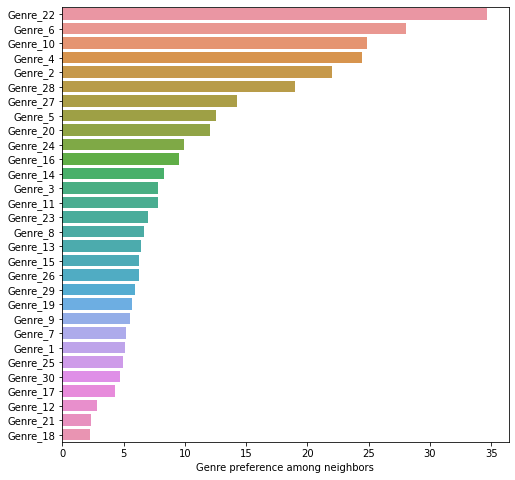

In [135]:
# Find top genres
fig, ax = plt.subplots(figsize=(8,8))
genre_ranking = pd.DataFrame(neighbor_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0
)
plt.xlabel("Genre preference among neighbors")
plt.show()

In [136]:
# Loop through genres in descending relevance order and print top 5 recs
for genre in genre_ranking.index:
    
    g = float(genre[6:])
    highest_rated_recs_genre = neighbor_user_ratings.query("main_genre == @g")\
        .groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .rename(columns={"book_id":"percent_similar_users_read"})

    highest_rated_recs_genre["percent_similar_users_read"] = highest_rated_recs_genre["percent_similar_users_read"] / n_neighbors

    print(genre)
    display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count"]].head())
    print("_____\n")

Genre_22


,title,avg_rating,ratings_count
13,"Kings of the Wyld (The Band, #1)",4.42,2285.0
16,Michael Moorcock's Elric of Melnibone,4.32,1137.0
12,Judas Unchained,4.30,21306.0
15,Lost Stars,4.25,9512.0
19,Pandora's Star,4.24,28964.0


_____

Genre_6


,title,avg_rating,ratings_count
21,The Story of Human Language,4.44,394.0
14,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0
11,Our Revolution: A Future to Believe In,4.29,2430.0
16,The Hero With a Thousand Faces,4.24,18378.0
1,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0


_____

Genre_10


,title,avg_rating,ratings_count
1,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0
4,"Don't Make Me Think, Revisited: A Common Sense...",4.24,4444.0
6,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0
0,"Boundaries: When to Say Yes, How to Say No to ...",4.19,13041.0
3,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0


_____

Genre_4


,title,avg_rating,ratings_count
0,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0
6,"Killer of Men (Long War, #1)",4.27,1176.0
16,The World of Ice & Fire: The Untold History of...,4.26,12952.0
1,Atlas of Remote Islands,4.24,1807.0
12,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0


_____

Genre_2


,title,avg_rating,ratings_count
2,"Berserk, Vol. 1 (Berserk, #1)",4.38,10778.0
20,The Tower of Swallows,4.33,288.0
21,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0
18,The Dark Tower,4.27,96576.0
7,"Lion of Macedon (Greek Series, #1)",4.24,3375.0


_____

Genre_28


,title,avg_rating,ratings_count
3,"After the Ecstasy, the Laundry: How the Heart ...",4.16,3187.0
11,The 50th Law,4.13,4254.0
9,Patriotism,4.12,1869.0
1,1914-1918: The History of the First World War,4.11,237.0
17,The Story of B: An Adventure of the Mind and S...,4.11,7822.0


_____

Genre_27


,title,avg_rating,ratings_count
7,The False Prince (The Ascendance Trilogy #1),4.23,51292.0
1,"American Gods (American Gods, #1)",4.11,1647.0
3,Darth Plagueis,4.08,9273.0
0,"Air Awakens (Air Awakens, #1)",4.01,9408.0
8,"The Gender Game (The Gender Game, #1)",3.90,13632.0


_____

Genre_5


,title,avg_rating,ratings_count
6,"Saga, Vol. 1 (Saga, #1)",4.24,142640.0
0,An Era of Darkness: The British Empire in India,4.23,875.0
12,The Winged Histories,4.09,282.0
2,Dawn (Legend of the Galactic Heroes #1),4.06,418.0
5,"One Second After (After, #1)",3.93,27302.0


_____

Genre_20


,title,avg_rating,ratings_count
10,The Authoritarians,4.31,354.0
2,Beyond the Aquila Rift: The Best of Alastair R...,4.30,163.0
12,The Circular Ruins,4.30,409.0
8,Man-Eaters of Kumaon,4.25,2609.0
1,Batman: Year One,4.22,308.0


_____

Genre_24


,title,avg_rating,ratings_count
0,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0
7,"The Forgetting (The Forgetting, #1)",3.98,4547.0
8,The Good House,3.93,1908.0
3,Miss Peregrine's Home For Peculiar Children (M...,3.89,25355.0
6,"The Forge of God (Forge of God, #1)",3.86,10215.0


_____

Genre_16


,title,avg_rating,ratings_count
8,"Working Stiff: Two Years, 262 Bodies, and the ...",4.11,8101.0
7,"UNSUB (UNSUB, #1)",4.03,1314.0
5,The Dispatcher,4.02,187.0
4,The Ballad of Black Tom,3.92,3986.0
3,Have Space Suit—Will Travel,3.89,20603.0


_____

Genre_14


,title,avg_rating,ratings_count
0,A Good Man is Hard to Find and Other Stories,4.24,26384.0
4,Superman: Birthright,4.12,9365.0
5,The Rest Is Noise: Listening to the Twentieth ...,4.08,9607.0
1,All the Names,3.88,9681.0
2,Inside Apple,3.78,4329.0


_____

Genre_3


,title,avg_rating,ratings_count
6,The Thousand Emperors,3.88,273.0
4,The Gauntlet,3.87,610.0
1,In Real Life,3.80,17433.0
3,Once Upon a Time in the North (His Dark Materi...,3.79,6830.0
0,Avogadro Corp (Singularity #1),3.78,2714.0


_____

Genre_11


,title,avg_rating,ratings_count
0,Nick Cave: Mercy on Me,4.30,175.0
2,Shrill,4.22,193.0
4,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0
1,"Searching for Sunday: Loving, Leaving, and Fin...",4.09,5560.0
3,So Big,4.00,5949.0


_____

Genre_23


,title,avg_rating,ratings_count
3,"Steelheart (The Reckoners, #1)",4.16,79287.0
1,"Gateway (Heechee Saga, #1)",4.07,30282.0
4,The Cobra Event,4.00,556.0
0,"Anomaly (Schrodinger's Consortium, #1)",3.75,977.0
2,Normal,3.70,1850.0


_____

Genre_8


,title,avg_rating,ratings_count
0,Bitch Planet #1,4.18,3120.0
2,"Spin (Spin, #1)",4.01,26520.0
3,The Awkward Thoughts of W. Kamau Bell: Tales o...,4.01,1395.0
4,The Black Tides of Heaven (Tensorate #1),3.99,321.0
1,Intrusion,3.41,840.0


_____

Genre_13


,title,avg_rating,ratings_count
5,The Complete Works of H.P. Lovecraft,4.34,9733.0
0,2016 on Goodreads,4.25,1167.0
2,Monkey Business: Swinging Through the Wall Str...,3.90,3346.0
4,Rogues,3.86,10516.0
1,Marilyn,3.78,1191.0


_____

Genre_15


,title,avg_rating,ratings_count
2,"Monstress, Vol. 1: Awakening (Monstress, #1)",4.01,16701.0
3,"Patient Zero (Joe Ledger, #1)",3.99,20264.0
0,Certain Dark Things,3.68,1003.0
1,Dracula vs. Hitler,3.61,508.0


_____

Genre_26


,title,avg_rating,ratings_count
0,Adventure Time With Fionna and Cake,4.41,2542.0
2,Lost Boy: The True Story of Captain Hook,4.20,1420.0
1,Black History In Its Own Words,4.15,190.0
3,"Pretty Deadly, Vol. 1: The Shrike",3.84,9218.0


_____

Genre_29


,title,avg_rating,ratings_count
3,Homicide: A Year on the Killing Streets,4.37,10487.0
0,Daemon (Daemon #1),4.17,9355.0
2,Down Town (The Dresden Files Graphic Novels),4.02,651.0
1,Dhalgren,3.79,6241.0
4,Look at Me,3.40,8290.0


_____

Genre_19


,title,avg_rating,ratings_count
3,"The Walking Dead, Compendium 1",4.43,58434.0
1,"Moon Girl and Devil Dinosaur, Vol. 1: BFF",3.88,3026.0
0,Honor Girl: A Graphic Memoir,3.83,4486.0
2,"The Lost Gate (Mither Mages, #1)",3.82,18675.0
4,Wake (Watersong #1),3.70,18054.0


_____

Genre_9


,title,avg_rating,ratings_count
2,"Wool Omnibus (Silo, #1)",4.24,83601.0
1,The Rose of Winslow Street,3.95,2776.0
0,Nightfall,3.40,2706.0


_____

Genre_7


,title,avg_rating,ratings_count
3,The Fisherman,4.01,1458.0
0,Mischling,3.89,6639.0
2,The Devil In Pew Number Seven,3.70,3640.0
1,Summer Reading,2.69,697.0


_____

Genre_1


,title,avg_rating,ratings_count
3,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0
1,Jauno žmogaus memuarai: Keturiolikos laiškų ro...,4.14,251.0
2,Night's Slow Poison (Imperial Radch #0.5),3.59,621.0
0,A Small Revolution,3.26,1287.0


_____

Genre_25


,title,avg_rating,ratings_count
0,Asterios Polyp,4.19,20053.0
3,"World Trigger, Vol. 1",4.05,584.0
2,"Touch of Death (Touch of Death, #1)",3.64,1026.0
1,The Idiot,3.57,3608.0


_____

Genre_30


,title,avg_rating,ratings_count
1,"On a Pale Horse (Incarnations of Immortality, #1)",4.14,29860.0
2,Rebel Rising,3.85,1060.0
0,Miserere: An Autumn Tale,3.79,747.0


_____

Genre_17


,title,avg_rating,ratings_count
2,The Good Brother: A Novel,3.73,185.0
1,"Soho Dead (The Soho, #1)",3.72,256.0
0,Duplicity,3.63,470.0


_____

Genre_12


,title,avg_rating,ratings_count
0,Universal Harvester,3.27,5863.0


_____

Genre_21


,title,avg_rating,ratings_count


_____

Genre_18


,title,avg_rating,ratings_count


_____

